In [85]:
import pandas as pd
import numpy as np
import nltk
import torch
from torch import nn
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
import torch.optim as optim
import string
import json
import csv
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

In [87]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to C:\Users\Pavan
[nltk_data]     Chandra\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Pavan
[nltk_data]     Chandra\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Pavan
[nltk_data]     Chandra\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [88]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [89]:
stop_words = set(nltk.corpus.stopwords.words('english'))
lemmatizer = nltk.stem.WordNetLemmatizer()

In [90]:
with open('Musical_Instruments_5.json', 'r') as json_file:
    data = json_file.read()

In [91]:
data = data.replace('\n', '').replace('}{', '},{')

data = f"[{data}]"

with open('structured_Musical_Instruments_data.json', 'w') as modified_file:
    modified_file.write(data)

In [92]:
with open('structured_Musical_Instruments_data.json', 'r') as json_file:
    data = json.load(json_file)

csv_file_name = 'Musical_Instruments_data.csv'

In [93]:
if data and isinstance(data[0], dict):
    field_names = list(data[0].keys())
    print("Field Names (Keys) from the JSON file:")
    print(field_names)
else:
    print("The JSON data is empty or not in the expected format.")

Field Names (Keys) from the JSON file:
['reviewerID', 'asin', 'reviewerName', 'helpful', 'reviewText', 'overall', 'summary', 'unixReviewTime', 'reviewTime']


In [94]:
with open(csv_file_name, 'w', newline='') as csv_file:
    fieldnames = ['reviewerID', 'asin', 'reviewerName', 'helpful', 'reviewText', 'overall', 'summary', 'unixReviewTime', 'reviewTime']  # Column headers for the CSV file
    writer = csv.DictWriter(csv_file, fieldnames=fieldnames)

    writer.writeheader()

    for item in data:
        writer.writerow(item)


In [95]:
data = pd.read_csv('Musical_Instruments_data.csv')
print(data.head())

       reviewerID        asin  \
0  A2IBPI20UZIR0U  1384719342   
1  A14VAT5EAX3D9S  1384719342   
2  A195EZSQDW3E21  1384719342   
3  A2C00NNG1ZQQG2  1384719342   
4   A94QU4C90B1AX  1384719342   

                                       reviewerName   helpful  \
0  cassandra tu "Yeah, well, that's just like, u...    [0, 0]   
1                                              Jake  [13, 14]   
2                     Rick Bennette "Rick Bennette"    [1, 1]   
3                         RustyBill "Sunday Rocker"    [0, 0]   
4                                     SEAN MASLANKA    [0, 0]   

                                          reviewText  overall  \
0  Not much to write about here, but it does exac...      5.0   
1  The product does exactly as it should and is q...      5.0   
2  The primary job of this device is to block the...      5.0   
3  Nice windscreen protects my MXL mic and preven...      5.0   
4  This pop filter is great. It looks and perform...      5.0   

                   

In [96]:
print(data.describe(include='all'))

           reviewerID        asin     reviewerName helpful  \
count           10261       10261            10234   10261   
unique           1429         900             1397     269   
top     ADH0O8UVJOT10  B003VWJ2K8  Amazon Customer  [0, 0]   
freq               42         163               66    6796   
mean              NaN         NaN              NaN     NaN   
std               NaN         NaN              NaN     NaN   
min               NaN         NaN              NaN     NaN   
25%               NaN         NaN              NaN     NaN   
50%               NaN         NaN              NaN     NaN   
75%               NaN         NaN              NaN     NaN   
max               NaN         NaN              NaN     NaN   

                                               reviewText       overall  \
count                                               10254  10261.000000   
unique                                              10254           NaN   
top     Not much to write abou

In [97]:
print(data.isnull().sum())

reviewerID         0
asin               0
reviewerName      27
helpful            0
reviewText         7
overall            0
summary            0
unixReviewTime     0
reviewTime         0
dtype: int64


In [98]:
data = data.dropna(subset=['reviewText'])

In [99]:
print(data.isnull().sum())

reviewerID         0
asin               0
reviewerName      27
helpful            0
reviewText         0
overall            0
summary            0
unixReviewTime     0
reviewTime         0
dtype: int64


In [100]:
print("Duplicates:", data.duplicated().sum())

Duplicates: 0


In [101]:
sentiment_list = []
for rating in data['overall']:
    rating_int = int(rating)
    if rating_int >= 3:
      sentiment = 1
    else:
      sentiment = 0
    sentiment_list.append(sentiment)
data['sentiment'] = sentiment_list
print(data.head())

       reviewerID        asin  \
0  A2IBPI20UZIR0U  1384719342   
1  A14VAT5EAX3D9S  1384719342   
2  A195EZSQDW3E21  1384719342   
3  A2C00NNG1ZQQG2  1384719342   
4   A94QU4C90B1AX  1384719342   

                                       reviewerName   helpful  \
0  cassandra tu "Yeah, well, that's just like, u...    [0, 0]   
1                                              Jake  [13, 14]   
2                     Rick Bennette "Rick Bennette"    [1, 1]   
3                         RustyBill "Sunday Rocker"    [0, 0]   
4                                     SEAN MASLANKA    [0, 0]   

                                          reviewText  overall  \
0  Not much to write about here, but it does exac...      5.0   
1  The product does exactly as it should and is q...      5.0   
2  The primary job of this device is to block the...      5.0   
3  Nice windscreen protects my MXL mic and preven...      5.0   
4  This pop filter is great. It looks and perform...      5.0   

                   

In [102]:
print(data['overall'].describe())


count    10254.000000
mean         4.488492
std          0.894849
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: overall, dtype: float64


In [103]:
cleaned_reviews = []  

for review in data['reviewText']:
    tokenized_review = nltk.word_tokenize(review) 

    cleaned_review = []  
    for word in tokenized_review:  
        word_lower = word.lower()
        if word_lower not in stop_words and word not in string.punctuation:
            lemmatized_word = lemmatizer.lemmatize(word_lower)
            cleaned_review.append(lemmatized_word)

    cleaned_reviews.append(cleaned_review)  
data['cleaned_review'] = cleaned_reviews
print(data.head())

       reviewerID        asin  \
0  A2IBPI20UZIR0U  1384719342   
1  A14VAT5EAX3D9S  1384719342   
2  A195EZSQDW3E21  1384719342   
3  A2C00NNG1ZQQG2  1384719342   
4   A94QU4C90B1AX  1384719342   

                                       reviewerName   helpful  \
0  cassandra tu "Yeah, well, that's just like, u...    [0, 0]   
1                                              Jake  [13, 14]   
2                     Rick Bennette "Rick Bennette"    [1, 1]   
3                         RustyBill "Sunday Rocker"    [0, 0]   
4                                     SEAN MASLANKA    [0, 0]   

                                          reviewText  overall  \
0  Not much to write about here, but it does exac...      5.0   
1  The product does exactly as it should and is q...      5.0   
2  The primary job of this device is to block the...      5.0   
3  Nice windscreen protects my MXL mic and preven...      5.0   
4  This pop filter is great. It looks and perform...      5.0   

                   

In [104]:

data = data.sample(frac=1, random_state=42)
split_idx = int(len(data) * 0.8)
train_data = data[:split_idx]
test_data = data[split_idx:]

In [105]:

word_to_ix = {"<PAD>": 0, "<UNK>": 1}
for review in train_data['cleaned_review']:
    for word in review:
        if word not in word_to_ix:
            word_to_ix[word] = len(word_to_ix)

vocab_size = len(word_to_ix)
print(vocab_size)
print(word_to_ix)

24783
{'<PAD>': 0, '<UNK>': 1, "'s": 2, 'hard': 3, 'love': 4, 'cord': 5, 'carry': 6, 'electron': 7, 'way': 8, 'end': 9, 'sure': 10, 'complete': 11, 'failure': 12, 'would': 13, 'take': 14, 'star': 15, 'away': 16, "n't": 17, 'know': 18, '39': 19, "''": 20, 'top': 21, 'headstock': 22, 'bottom': 23, 'body': 24, 'guitar': 25, 'based': 26, 'size': 27, 'fret': 28, 'idea': 29, 'normal': 30, 'adult': 31, '...': 32, 'however': 33, '50': 34, 'sale': 35, 'time': 36, 'even': 37, 'still': 38, 'learn': 39, 'play': 40, 'since': 41, 'thats': 42, 'bought': 43, 'pick': 44, 'guard': 45, 'sort': 46, 'plastic': 47, 'cover': 48, 'rough': 49, 'really': 50, 'affect': 51, 'anything': 52, 'seems': 53, 'like': 54, 'something': 55, 'put': 56, 'help': 57, 'shipping': 58, 'removed': 59, 'fine.all': 60, 'togther': 61, 'whether': 62, 'full': 63, 'one': 64, 'kid': 65, 'pretty': 66, 'good.i': 67, 'happy': 68, 'it.good': 69, 'clean': 70, 'sound': 71, 'least': 72, 'headphone': 73, 'amp': 74, '.comes': 75, 'whammy': 76, 'b

In [106]:

for index, row in train_data.iterrows():
    cleaned_review = []
    for word in row['cleaned_review']:
        if word in word_to_ix:
            cleaned_review.append(word_to_ix[word])
        else:
            cleaned_review.append(word_to_ix["<UNK>"])
    train_data.at[index, 'cleaned_review'] = cleaned_review


for index, row in test_data.iterrows():
    cleaned_review = []
    for word in row['cleaned_review']:
        if word in word_to_ix:
            cleaned_review.append(word_to_ix[word])
        else:
            cleaned_review.append(word_to_ix["<UNK>"])
    test_data.at[index, 'cleaned_review'] = cleaned_review


In [107]:

max_len = max(max(len(review) for review in train_data['cleaned_review']), max(len(review) for review in test_data['cleaned_review']))


train_data['cleaned_review'] = [(review + [word_to_ix["<PAD>"]] * (max_len - len(review))) for review in train_data['cleaned_review']]
test_data['cleaned_review'] = [(review + [word_to_ix["<PAD>"]] * (max_len - len(review))) for review in test_data['cleaned_review']]

C:\temp\ipykernel_27468\980311394.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['cleaned_review'] = [(review + [word_to_ix["<PAD>"]] * (max_len - len(review))) for review in train_data['cleaned_review']]
C:\temp\ipykernel_27468\980311394.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['cleaned_review'] = [(review + [word_to_ix["<PAD>"]] * (max_len - len(review))) for review in test_data['cleaned_review']]


In [117]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [118]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased').to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [119]:
train_encodings = tokenizer(train_data['reviewText'].tolist(), truncation=True, padding=True, max_length=256)
train_labels = torch.tensor(train_data['sentiment'].tolist())

test_encodings = tokenizer(test_data['reviewText'].tolist(), truncation=True, padding=True, max_length=256)
test_labels = torch.tensor(test_data['sentiment'].tolist())

n_epochs = 10

In [120]:
train_datasetbert = TensorDataset(torch.tensor(train_encodings['input_ids']).to(device),
                                  torch.tensor(train_encodings['attention_mask']).to(device),
                                  torch.tensor(train_labels).to(device))

test_datasetbert = TensorDataset(torch.tensor(test_encodings['input_ids']).to(device),
                                 torch.tensor(test_encodings['attention_mask']).to(device),
                                 torch.tensor(test_labels).to(device))


C:\temp\ipykernel_27468\2277621348.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(train_labels).to(device))
C:\temp\ipykernel_27468\2277621348.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(test_labels).to(device))


In [122]:
batch_size = 16
train_loaderbert = DataLoader(train_datasetbert, batch_size=batch_size)
test_loaderbert = DataLoader(test_datasetbert, batch_size=batch_size)

In [115]:
optimizerbert = AdamW(model.parameters(), lr=1e-3)
torch.cuda.empty_cache()

In [124]:

model.train()
for epoch in range(n_epochs):
    print(f'Epoch {epoch+1}/{n_epochs}')
    epoch_loss = 0

    
    for batch in tqdm(train_loaderbert, total=len(train_loaderbert), unit='batch'):
        optimizerbert.zero_grad()
        input_ids, attention_mask, labels = tuple(t.to(device) for t in batch)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs[0] 
        epoch_loss += loss.item()  
        loss.backward()
        optimizerbert.step()

    
    print(f'Train loss for epoch {epoch+1}: {epoch_loss / len(train_loaderbert)}')

Epoch 1/10


100%|██████████| 513/513 [06:18<00:00,  1.36batch/s]


Train loss for epoch 1: 0.20559948550529966
Epoch 2/10


100%|██████████| 513/513 [06:19<00:00,  1.35batch/s]


Train loss for epoch 2: 0.210417120302637
Epoch 3/10


100%|██████████| 513/513 [06:19<00:00,  1.35batch/s]


Train loss for epoch 3: 0.20337443010514825
Epoch 4/10


100%|██████████| 513/513 [06:20<00:00,  1.35batch/s]


Train loss for epoch 4: 0.2032122125887252
Epoch 5/10


100%|██████████| 513/513 [06:20<00:00,  1.35batch/s]


Train loss for epoch 5: 0.20308420637742294
Epoch 6/10


100%|██████████| 513/513 [06:20<00:00,  1.35batch/s]


Train loss for epoch 6: 0.2031710787329525
Epoch 7/10


100%|██████████| 513/513 [06:21<00:00,  1.35batch/s]


Train loss for epoch 7: 0.20404785206690285
Epoch 8/10


100%|██████████| 513/513 [06:21<00:00,  1.35batch/s]


Train loss for epoch 8: 0.20458195058331183
Epoch 9/10


100%|██████████| 513/513 [06:21<00:00,  1.34batch/s]


Train loss for epoch 9: 0.20344151169076186
Epoch 10/10


100%|██████████| 513/513 [06:20<00:00,  1.35batch/s]

Train loss for epoch 10: 0.204508198228652


In [140]:
model.eval()
correct = 0
predictions, true_labels = [], []
with torch.no_grad():
    for batch in test_loaderbert:
        input_ids, attention_mask, labels = tuple(t.to(device) for t in batch)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        
        preds = (outputs.logits.squeeze() > 0.5).long()
        preds = torch.argmax(preds, dim=1)
        correct += (preds == labels).sum().item()
        
        
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())


bert_accuracy = correct / len(test_datasetbert)
print("\nBERT model test accuracy: ", bert_accuracy)


BERT model test accuracy:  0.978943765983


In [ ]:
def train_model(train_data, batch_size, n_epochs, embedding, lstm, linear, sigmoid, criterion, optimizer, device):
    num_batches = len(train_data) // batch_size
    loss_list = []
    for epoch in range(n_epochs):
        for i in range(0, len(train_data), batch_size):
            batch = train_data[i:i+batch_size]
            sequences_list = [item for item in batch['cleaned_review']]
            sequences = torch.tensor(sequences_list, device=device)  
            sentiments_list = [item for item in batch['sentiment']]
            sentiments = torch.tensor(sentiments_list, dtype=torch.float, device=device)  

            embeds = embedding(sequences)
            lstm_out, _ = lstm(embeds)
            final_hidden = lstm_out[:, -1, :]
            linear_out = linear(final_hidden)
            outputs = sigmoid(linear_out)
            loss = criterion(outputs.squeeze(), sentiments)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            progress = (i // batch_size) / num_batches
            progress_bar = '=' * int(progress * 50) + '>' + ' ' * (49 - int(progress * 50))
            print(f'\rEpoch {epoch+1}/{n_epochs} [{progress_bar}] {progress * 100:.2f}%', end='')

        loss_list.append(loss.item())
        print(f'\rEpoch {epoch+1}/{n_epochs} Loss: {loss.item()}')

    return loss_list


In [ ]:
def evaluate_model(test_data, batch_size, embedding, lstm, linear, sigmoid, device):
    correct = 0
    num_batches = len(test_data) // batch_size
    predictions = []
    true_labels = []
    with torch.no_grad():
        for i in range(0, len(test_data), batch_size):
            batch = test_data[i:i+batch_size]
            sequences_list = [item for item in batch['cleaned_review']]
            sequences = torch.tensor(sequences_list, device=device)
            sentiments_list = [item for item in batch['sentiment']]
            sentiments = torch.tensor(sentiments_list, dtype=torch.float, device=device)

            embeds = embedding(sequences)
            lstm_out, _ = lstm(embeds)
            final_hidden = lstm_out[:, -1, :]
            linear_out = linear(final_hidden)
            outputs = sigmoid(linear_out)
            predicted = (outputs > 0.5).float()
            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(sentiments.cpu().numpy())
            correct += (predicted.squeeze() == sentiments).sum().item()

            progress = (i // batch_size) / num_batches
            progress_bar = '=' * int(progress * 50) + '>' + ' ' * (49 - int(progress * 50))
            print(f'\rTest Progress: [{progress_bar}] {progress * 100:.2f}%', end='')

    accuracy = correct / len(test_data)
    # print(f'\nTest Accuracy: {accuracy*100}')

    return accuracy*100, predictions, true_labels



In [ ]:
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10,7))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    plt.show()


In [ ]:
def plot_loss_vs_epoch(n_epochs, loss_list):
    plt.plot(range(n_epochs), loss_list)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss vs. Epoch')
    plt.show()

In [129]:

embedding_dim = 100
hidden_dim = 256
output_dim = 1
batch_size = 32


embedding = nn.Embedding(vocab_size, embedding_dim).to(device)
lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True).to(device)
linear = nn.Linear(hidden_dim, output_dim).to(device)
sigmoid = nn.Sigmoid().to(device)

In [130]:

criterion11 = nn.BCEWithLogitsLoss()
optimizer11 = torch.optim.Adam(list(embedding.parameters()) + list(lstm.parameters()) + list(linear.parameters()))
n_epochs = 10
model_11_loss_list = train_model(train_data, batch_size, n_epochs, embedding, lstm, linear, sigmoid, criterion11, optimizer11, device)
print("model_11_loss_list: ",model_11_loss_list)
model_11_accuracy, model_11_predictions, model_11_true_labels = evaluate_model(test_data, batch_size, embedding, lstm, linear, sigmoid,  device)
print("\nmodel_11_accuracy: ",model_11_accuracy)

Epoch 1/10 Loss: 0.40418100357055664
Epoch 2/10 Loss: 0.40417516231536865
Epoch 3/10 Loss: 0.4041732847690582
Epoch 4/10 Loss: 0.4041723906993866
Epoch 5/10 Loss: 0.4041719138622284
Epoch 6/10 Loss: 0.4041716456413269
Epoch 7/10 Loss: 0.4041713774204254
Epoch 8/10 Loss: 0.40417131781578064
Epoch 9/10 Loss: 0.4041711390018463
Epoch 10/10 Loss: 0.40417107939720154
model_11_loss_list:  [0.40418100357055664, 0.40417516231536865, 0.4041732847690582, 0.4041723906993866, 0.4041719138622284, 0.4041716456413269, 0.4041713774204254, 0.40417131781578064, 0.4041711390018463, 0.40417107939720154]
Test Progress: [==================================================>] 100.00%
model_11_accuracy:  95.465626523647


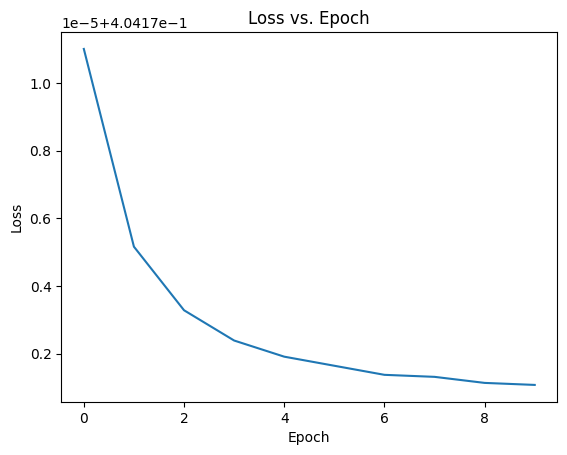

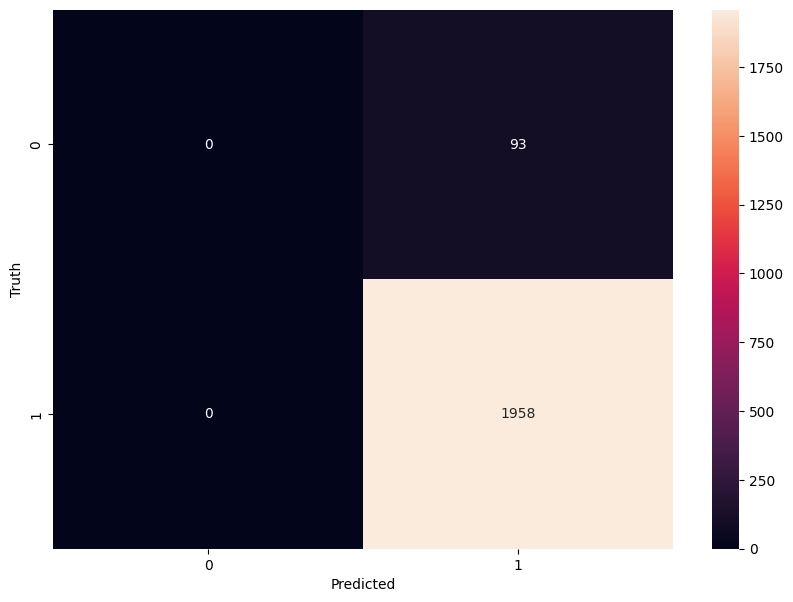

In [131]:
from sklearn.metrics import roc_curve, auc
plot_loss_vs_epoch(n_epochs, model_11_loss_list)
cm = plot_confusion_matrix(model_11_true_labels, model_11_predictions)

In [132]:

embedding_dim = 200
hidden_dim = 256
output_dim = 1
batch_size = 64

embedding1 = nn.Embedding(vocab_size, embedding_dim).to(device)
lstm1 = nn.LSTM(embedding_dim, hidden_dim, batch_first=True).to(device)
linear = nn.Linear(hidden_dim, output_dim).to(device)
sigmoid = nn.Sigmoid().to(device)

In [134]:
criterion12 = nn.MSELoss()
optimizer12 = torch.optim.SGD(list(embedding.parameters()) + list(lstm.parameters()) + list(linear.parameters()), lr=0.01)
n_epochs = 10
model_12_loss_list = train_model(train_data, batch_size, n_epochs, embedding, lstm, linear, sigmoid, criterion12, optimizer12, device)
print("model_12_loss_list: ",model_12_loss_list)
model_12_accuracy, model_12_predictions, model_12_true_labels = evaluate_model(test_data, batch_size, embedding, lstm, linear, sigmoid,  device)
print("\nmodel_12_accuracy: ",model_12_accuracy)

Epoch 1/10 Loss: 0.08409246802330017
Epoch 2/10 Loss: 0.08408630391836167
Epoch 3/10 Loss: 0.08408270043420792
Epoch 4/10 Loss: 0.08408017685461044
Epoch 5/10 Loss: 0.08407898602485657
Epoch 6/10 Loss: 0.08407824111747741
Epoch 7/10 Loss: 0.08407795556211473
Epoch 8/10 Loss: 0.08407754299230576
Epoch 9/10 Loss: 0.0840772622015953
Epoch 10/10 Loss: 0.08407706964449829
model_12_loss_list:  [0.08409246802330017, 0.08408630391836167, 0.08408270043420792, 0.08408017685461044, 0.08407898602485657, 0.08407824111747741, 0.08407795556211473, 0.08407754299230576, 0.0840772622015953, 0.08407706964449829]
Test Progress: [==================================================>] 100.00%
model_12_accuracy: 94.24962117972457


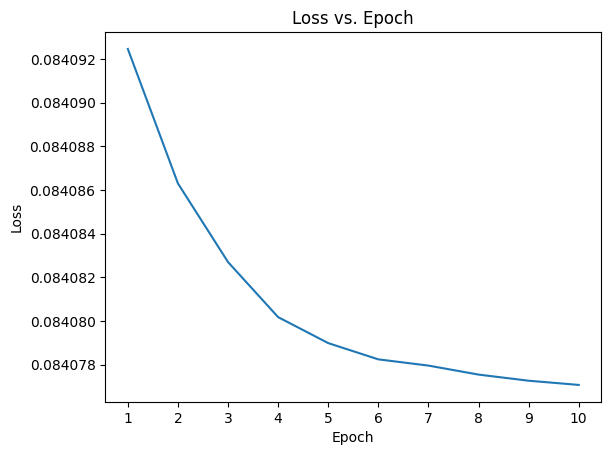

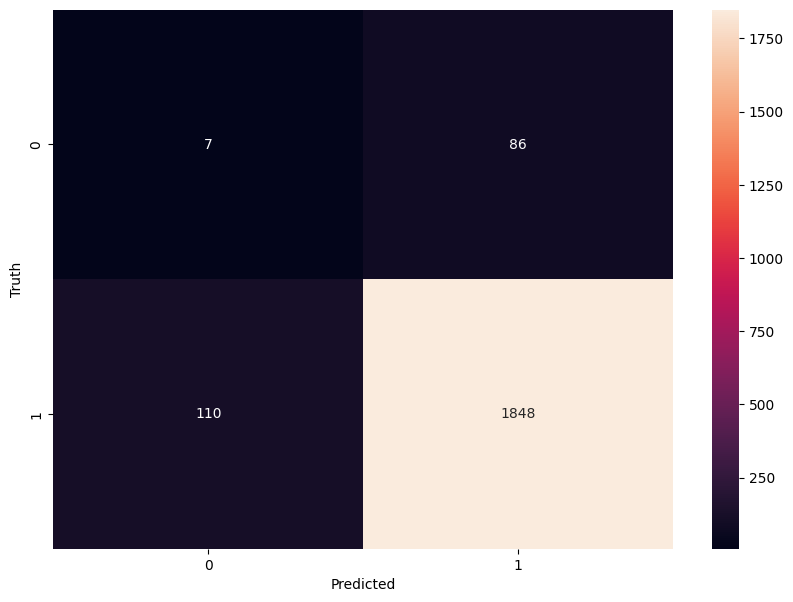

In [135]:
n_epochs = 10
def plot_loss_vs_epoch1(n_epochs, loss_list):
    epochs = list(range(1, n_epochs + 1))  
    plt.plot(epochs, loss_list)  
    plt.xticks(epochs)  
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss vs. Epoch')
    plt.show()
plot_loss_vs_epoch1(n_epochs, model_12_loss_list)
plot_confusion_matrix(model_12_true_labels, model_12_predictions)

In [136]:

embedding_dim = 100
hidden_dim = 256
output_dim = 1
batch_size = 32


embedding = nn.Embedding(vocab_size, embedding_dim).to(device)
lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True).to(device)
linear = nn.Linear(hidden_dim, output_dim).to(device)
sigmoid = nn.Sigmoid().to(device)

In [137]:
criterion13 = torch.nn.L1Loss()
optimizer13 = torch.optim.Adam(list(embedding.parameters()) +  list(lstm.parameters()) + list(linear.parameters()), lr=0.001)
n_epochs = 10
model_13_loss_list = train_model(train_data, batch_size, n_epochs, embedding, lstm, linear, sigmoid, criterion13, optimizer13, device)
print("model_13_loss_list: ",model_13_loss_list)
model_13_accuracy, model_13_predictions, model_13_true_labels = evaluate_model(test_data, batch_size, embedding, lstm, linear, sigmoid,  device)
print("\nmodel_13_accuracy: ",model_13_accuracy)


Epoch 1/10 Loss: 0.0909382551908493
Epoch 2/10 Loss: 0.09092137962579727
Epoch 3/10 Loss: 0.09091591835021973
Epoch 4/10 Loss: 0.09091357886791229
Epoch 5/10 Loss: 0.09091221541166306
Epoch 6/10 Loss: 0.09091143310070038
Epoch 7/10 Loss: 0.09091094881296158
Epoch 8/10 Loss: 0.09091055393218994
Epoch 9/10 Loss: 0.09091026335954666
Epoch 10/10 Loss: 0.09091006964445114
model_13_loss_list:  [0.0909382551908493, 0.09092137962579727, 0.09091591835021973, 0.09091357886791229, 0.09091221541166306, 0.09091143310070038, 0.09091094881296158, 0.09091055393218994, 0.09091026335954666, 0.09091006964445114]
Test Progress: [==================================================>] 100.00%
model_13_accuracy:  94.9812594389007


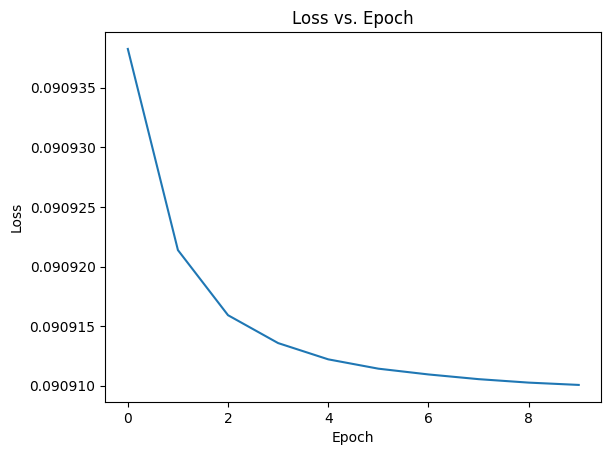

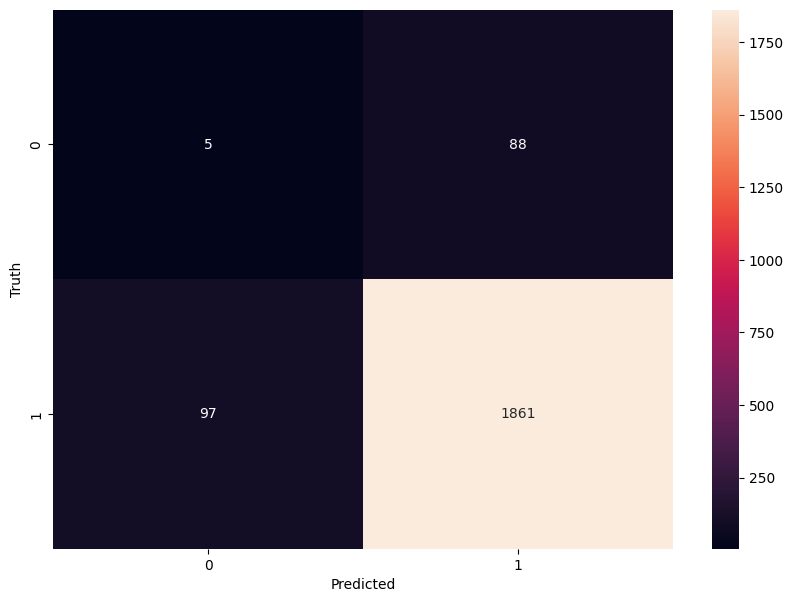

In [138]:
plot_loss_vs_epoch(n_epochs, model_13_loss_list)
plot_confusion_matrix(model_13_true_labels, model_13_predictions)

In [139]:

embedding_dim = 100
hidden_dim = 256
output_dim = 1
batch_size = 32


embedding = nn.Embedding(vocab_size, embedding_dim).to(device)
gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True).to(device)
linear = nn.Linear(hidden_dim, output_dim).to(device)
sigmoid = nn.Sigmoid().to(device)


In [140]:

criterion21 = nn.BCEWithLogitsLoss()
optimizer21 = torch.optim.Adam(list(embedding.parameters()) + list(gru.parameters()) + list(linear.parameters()), lr=0.001)
n_epochs = 10
model_21_loss_list = train_model(train_data, batch_size, n_epochs, embedding, gru, linear, sigmoid, criterion21, optimizer21, device)
print("model_21_loss_list: ",model_21_loss_list)
model_21_accuracy, model_21_predictions, model_21_true_labels = evaluate_model(test_data, batch_size, embedding, gru, linear, sigmoid,  device)
print("\nmodel_21_accuracy: ",model_21_accuracy)


Epoch 1/10 Loss: 0.40418314933776855
Epoch 2/10 Loss: 0.4041765034198761
Epoch 3/10 Loss: 0.40417417883872986
Epoch 4/10 Loss: 0.4041730463504791
Epoch 5/10 Loss: 0.404172420501709
Epoch 6/10 Loss: 0.4041719436645508
Epoch 7/10 Loss: 0.4041717052459717
Epoch 8/10 Loss: 0.4041714370250702
Epoch 9/10 Loss: 0.404171347618103
Epoch 10/10 Loss: 0.4041712284088135
model_21_loss_list:  [0.40418314933776855, 0.4041765034198761, 0.40417417883872986, 0.4041730463504791, 0.404172420501709, 0.4041719436645508, 0.4041717052459717, 0.4041714370250702, 0.404171347618103, 0.4041712284088135]
Test Progress: [==================================================>] 100.00%
model_21_accuracy:  95.21079130939964


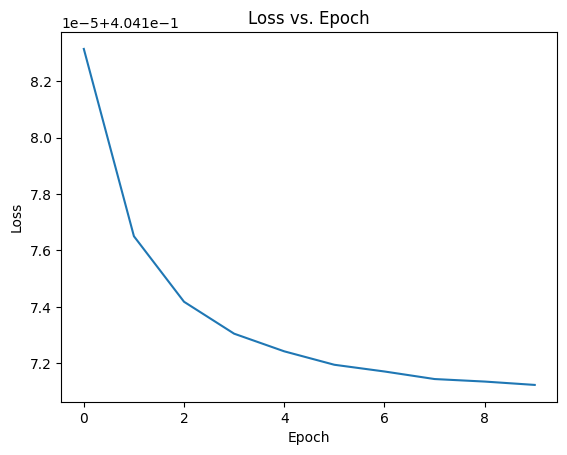

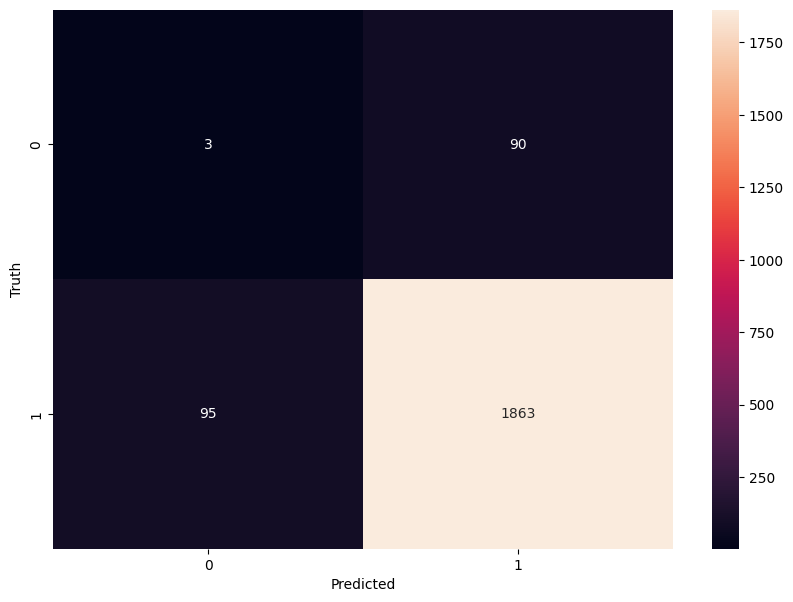

In [141]:
plot_loss_vs_epoch(n_epochs, model_21_loss_list)
plot_confusion_matrix(model_21_true_labels, model_21_predictions)

In [142]:

embedding_dim = 100
hidden_dim = 256
output_dim = 1
batch_size = 32


embedding = nn.Embedding(vocab_size, embedding_dim).to(device)
gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True).to(device)
linear = nn.Linear(hidden_dim, output_dim).to(device)
sigmoid = nn.Sigmoid().to(device)


In [143]:
criterion22 = nn.MSELoss()
optimizer22 = torch.optim.SGD(list(embedding.parameters()) + list(gru.parameters()) + list(linear.parameters()), lr=0.0001)
n_epochs = 10
model_22_loss_list = train_model(train_data, batch_size, n_epochs, embedding, gru, linear, sigmoid, criterion22, optimizer22, device)
print("model_22_loss_list: ",model_22_loss_list)
model_22_accuracy, model_22_predictions, model_22_true_labels = evaluate_model(test_data, batch_size, embedding, gru, linear, sigmoid,  device)
print("\nmodel_22_accuracy: ",model_22_accuracy)


Epoch 1/10 Loss: 0.20946621894836426
Epoch 2/10 Loss: 0.16545771062374115
Epoch 3/10 Loss: 0.1385459005832672
Epoch 4/10 Loss: 0.12177969515323639
Epoch 5/10 Loss: 0.11095543950796127
Epoch 6/10 Loss: 0.10369674116373062
Epoch 7/10 Loss: 0.09865573793649673
Epoch 8/10 Loss: 0.09504632651805878
Epoch 9/10 Loss: 0.09239355474710464
Epoch 10/10 Loss: 0.09040010720491409
model_22_loss_list:  [0.20946621894836426, 0.16545771062374115, 0.1385459005832672, 0.12177969515323639, 0.11095543950796127, 0.10369674116373062, 0.09865573793649673, 0.09504632651805878, 0.09239355474710464, 0.09040010720491409]
Test Progress: [==================================================>] 100.00%
model_22_accuracy:  94.31489280285803


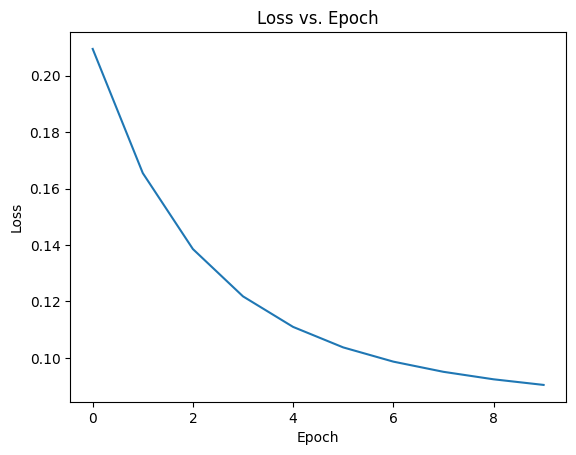

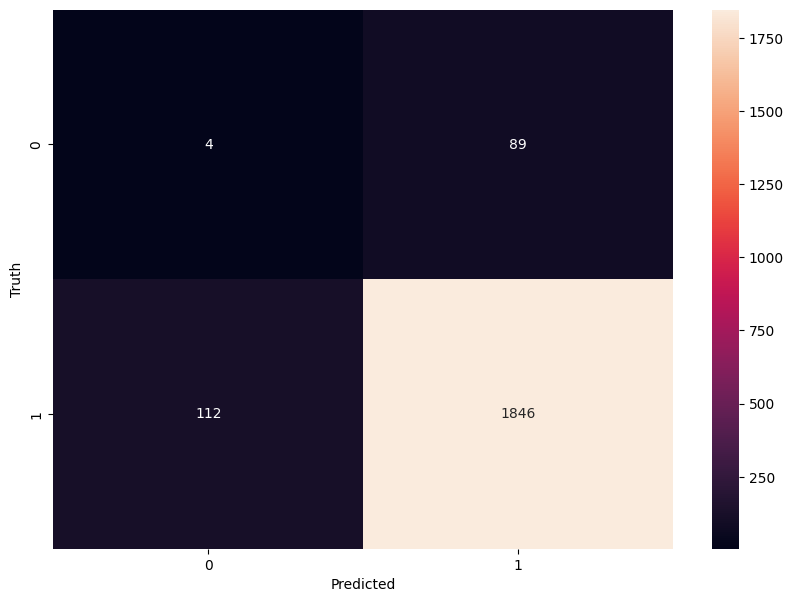

In [144]:
plot_loss_vs_epoch(n_epochs, model_22_loss_list)
plot_confusion_matrix(model_22_true_labels, model_22_predictions)

In [145]:

embedding_dim = 100
hidden_dim = 256
output_dim = 1
batch_size = 32


embedding = nn.Embedding(vocab_size, embedding_dim).to(device)
gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True).to(device)
linear = nn.Linear(hidden_dim, output_dim).to(device)
sigmoid = nn.Sigmoid().to(device)


In [146]:
criterion23 = torch.nn.L1Loss()
optimizer23 = torch.optim.Adam(list(embedding.parameters()) +  list(gru.parameters()) + list(linear.parameters()), lr=0.001)
n_epochs = 10
model_23_loss_list = train_model(train_data, batch_size, n_epochs, embedding, gru, linear, sigmoid, criterion23, optimizer23, device)
print("model_23_loss_list: ",model_23_loss_list)
model_23_accuracy, model_23_predictions, model_23_true_labels = evaluate_model(test_data, batch_size, embedding, gru, linear, sigmoid,  device)
print("\nmodel_23_accuracy: ",model_23_accuracy)


Epoch 1/10 Loss: 0.09094927459955215
Epoch 2/10 Loss: 0.09092859923839569
Epoch 3/10 Loss: 0.09092060476541519
Epoch 4/10 Loss: 0.0909167006611824
Epoch 5/10 Loss: 0.09091455489397049
Epoch 6/10 Loss: 0.09091319143772125
Epoch 7/10 Loss: 0.09091221541166306
Epoch 8/10 Loss: 0.09091152995824814
Epoch 9/10 Loss: 0.09091104567050934
Epoch 10/10 Loss: 0.09091075509786606
model_23_loss_list:  [0.09094927459955215, 0.09092859923839569, 0.09092060476541519, 0.0909167006611824, 0.09091455489397049, 0.09091319143772125, 0.09091221541166306, 0.09091152995824814, 0.09091104567050934, 0.09091075509786606]
Test Progress: [==================================================>] 100.00%
model_23_accuracy:  94.67273163415389


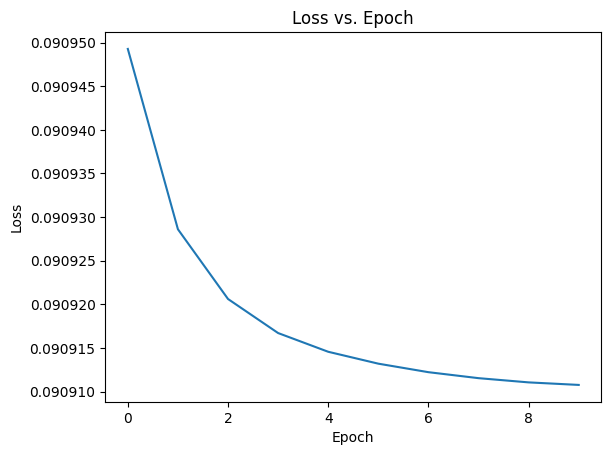

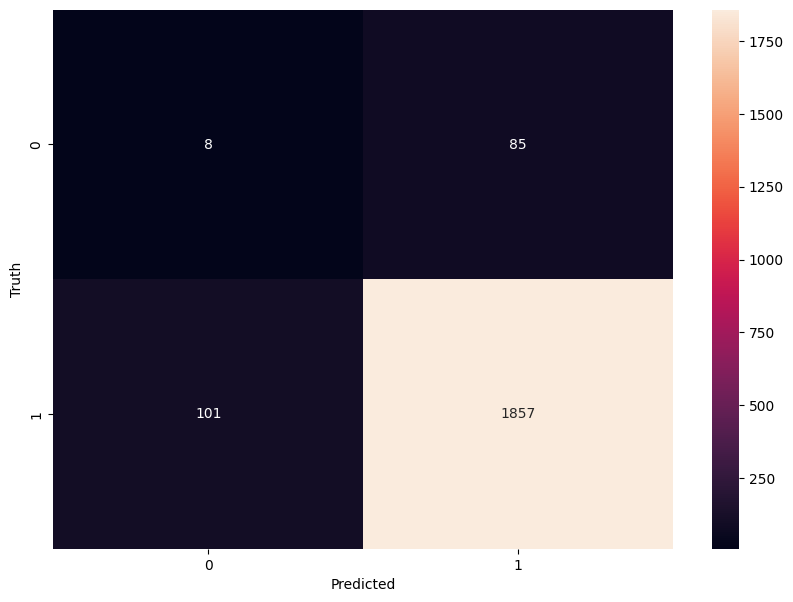

In [147]:
plot_loss_vs_epoch(n_epochs, model_23_loss_list)
plot_confusion_matrix(model_23_true_labels, model_23_predictions)

In [148]:

class CNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_filters, filter_sizes, output_dim, dropout):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.convs = nn.ModuleList([
                                    nn.Conv2d(in_channels=1,
                                              out_channels=num_filters,
                                              kernel_size=(fs, embedding_dim))
                                    for fs in filter_sizes
                                    ])
        self.fc = nn.Linear(len(filter_sizes) * num_filters, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
      embedded = self.embedding(text)
      embedded = embedded.unsqueeze(1)
      conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]
      pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
      cat = self.dropout(torch.cat(pooled, dim=1))
      return self.fc(cat).squeeze(1)


In [149]:
def train_model_cnn(train_data, batch_size, n_epochs, cnn_model, criterion, optimizer, device):
    num_batches = len(train_data) // batch_size
    loss_list = []
    for epoch in range(n_epochs):
        for i in range(0, len(train_data), batch_size):
            batch = train_data[i:i+batch_size]
            sequences_list = [item for item in batch['cleaned_review']]
            sequences = torch.tensor(sequences_list, device=device)  
            sentiments_list = [item for item in batch['sentiment']]
            sentiments = torch.tensor(sentiments_list, dtype=torch.float, device=device)  
            outputs = cnn_model(sequences)
            loss = criterion(outputs, sentiments)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            progress = (i // batch_size) / num_batches
            progress_bar = '=' * int(progress * 50) + '>' + ' ' * (49 - int(progress * 50))
            print(f'\rEpoch {epoch+1}/{n_epochs} [{progress_bar}] {progress * 100:.2f}%', end='')

        loss_list.append(loss.item())
        print(f'\rEpoch {epoch+1}/{n_epochs} Loss: {loss.item()}')

    return loss_list


In [150]:
def evaluate_model_cnn(test_data, batch_size, cnn_model, device):
    correct = 0
    predictions = []
    true_labels = []
    num_batches = len(test_data) // batch_size

    with torch.no_grad():
        for i in range(0, len(test_data), batch_size):
            batch = test_data[i:i+batch_size]
            sequences_list = [item for item in batch['cleaned_review']]
            sequences = torch.tensor(sequences_list, device=device)
            sentiments_list = [item for item in batch['sentiment']]
            sentiments = torch.tensor(sentiments_list, dtype=torch.float, device=device) 

            outputs = cnn_model(sequences)
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            predictions.extend(predicted.squeeze().detach().cpu().numpy())
            true_labels.extend(sentiments.squeeze().detach().cpu().numpy())
            correct += (predicted.squeeze() == sentiments).sum().item()
            progress = (i // batch_size) / num_batches
            progress_bar = '=' * int(progress * 50) + '>' + ' ' * (49 - int(progress * 50))
            print(f'\rTest Progress: [{progress_bar}] {progress * 100:.2f}%', end='')

    accuracy = correct / len(test_data)
    # print(f'\nTest Accuracy: {accuracy*100}')

    return accuracy*100, predictions, true_labels


In [151]:
embedding_dim = 200
num_filters = 100
filter_sizes = [3, 4, 5]
output_dim = 1
dropout = 0.5
batch_size = 64

In [152]:

model31 = CNN(vocab_size, embedding_dim, num_filters, filter_sizes, output_dim, dropout).to(device)

criterion31 = nn.BCEWithLogitsLoss()
optimizer31 = torch.optim.Adam(model31.parameters())
n_epochs = 10
model_31_loss_list = train_model_cnn(train_data, batch_size, n_epochs, model31, criterion31, optimizer31, device)
print("model_31_loss_list: ",model_31_loss_list)
model_31_accuracy, model_31_predictions, model_31_true_labels = evaluate_model_cnn(test_data, batch_size, model31, device)
print("\nmodel_31_accuracy: ",model_31_accuracy)

Epoch 1/10 Loss: 0.12175747752189636
Epoch 2/10 Loss: 0.035316403955221176
Epoch 3/10 Loss: 0.021356552839279175
Epoch 4/10 Loss: 0.004731564316898584
Epoch 5/10 Loss: 0.0010427801171317697
Epoch 6/10 Loss: 0.002502672839909792
Epoch 7/10 Loss: 6.473068060586229e-05
Epoch 8/10 Loss: 0.0023635930847376585
Epoch 9/10 Loss: 0.0035756644792854786
Epoch 10/10 Loss: 0.0010640161344781518
model_31_loss_list:  [0.12175747752189636, 0.035316403955221176, 0.021356552839279175, 0.004731564316898584, 0.0010427801171317697, 0.002502672839909792, 6.473068060586229e-05, 0.0023635930847376585, 0.0035756644792854786, 0.0010640161344781518]
Test Progress: [==================================================>] 100.00%
model_31_accuracy:  94.49049244271087


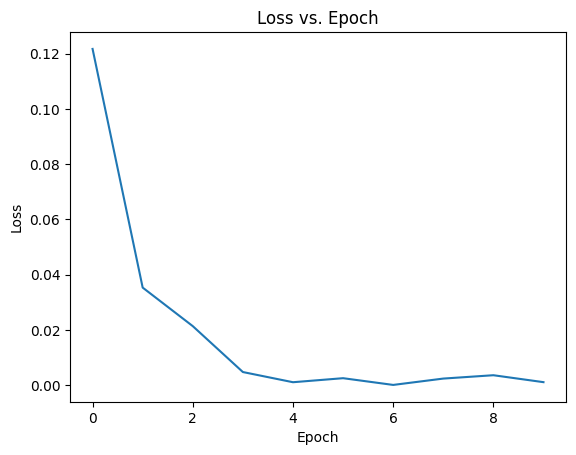

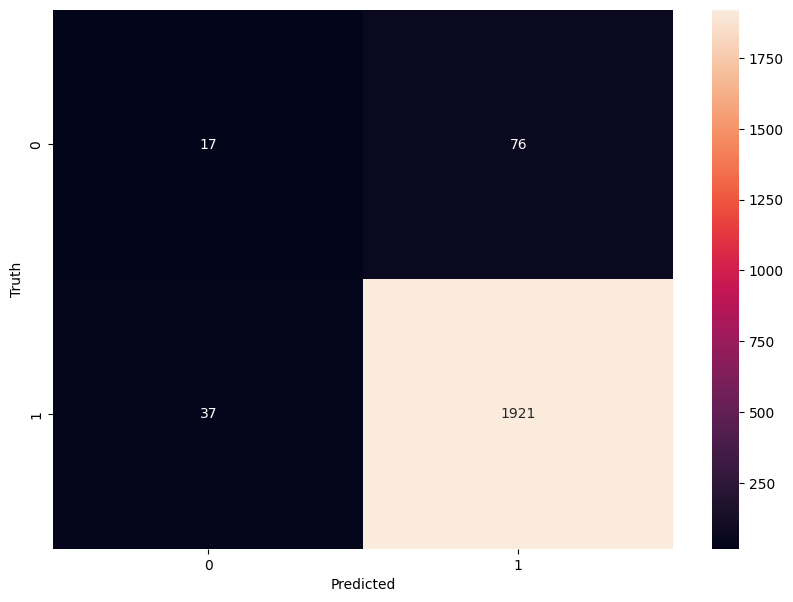

In [153]:
plot_loss_vs_epoch(n_epochs, model_31_loss_list)
plot_confusion_matrix(model_31_true_labels, model_31_predictions)

In [154]:

embedding_dim = 200
num_filters = 100
filter_sizes = [3, 4, 5]
output_dim = 1
dropout = 0.5
batch_size = 64

In [155]:

model32 = CNN(vocab_size, embedding_dim, num_filters, filter_sizes, output_dim, dropout).to(device)


criterion32 = nn.MSELoss()
optimizer32 = torch.optim.SGD(model32.parameters(), lr=0.003)
n_epochs = 10
model_32_loss_list = train_model_cnn(train_data, batch_size, n_epochs, model32, criterion32, optimizer32, device)
print("model_32_loss_list: ",model_32_loss_list)
model_32_accuracy, model_32_predictions, model_32_true_labels = evaluate_model_cnn(test_data, batch_size, model32, device)
print("\nmodel_32_accuracy: ",model_32_accuracy)

Epoch 1/10 Loss: 0.23076283931732178
Epoch 2/10 Loss: 0.23346608877182007
Epoch 3/10 Loss: 0.08810172975063324
Epoch 4/10 Loss: 0.09165241569280624
Epoch 5/10 Loss: 0.12739785015583038
Epoch 6/10 Loss: 0.12355421483516693
Epoch 7/10 Loss: 0.10147259384393692
Epoch 8/10 Loss: 0.1002747192978859
Epoch 9/10 Loss: 0.11238598823547363
Epoch 10/10 Loss: 0.07161233574151993
model_32_loss_list:  [0.23076283931732178, 0.23346608877182007, 0.08810172975063324, 0.09165241569280624, 0.12739785015583038, 0.12355421483516693, 0.10147259384393692, 0.1002747192978859, 0.11238598823547363, 0.07161233574151993]
Test Progress: [==================================================>] 100.00%
model_32_accuracy:  95.465626523647


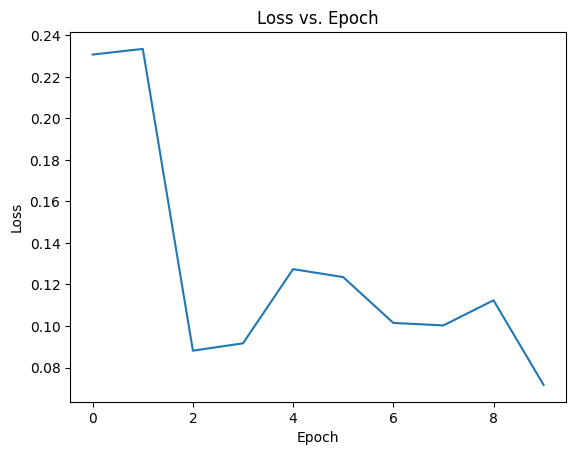

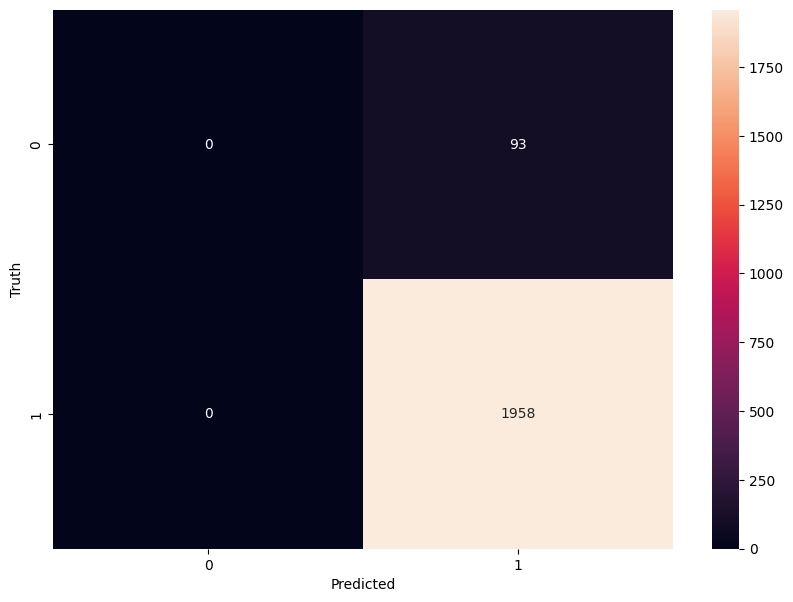

In [156]:
plot_loss_vs_epoch(n_epochs, model_32_loss_list)
plot_confusion_matrix(model_32_true_labels, model_32_predictions)

In [157]:

embedding_dim = 200
num_filters = 100
filter_sizes = [3, 4, 5]
output_dim = 1
dropout = 0.5
batch_size = 64

In [158]:

model33 = CNN(vocab_size, embedding_dim, num_filters, filter_sizes, output_dim, dropout).to(device)


criterion33 = torch.nn.L1Loss()
optimizer33 = torch.optim.Adam(model32.parameters(), lr=0.001)
n_epochs = 10
model_33_loss_list = train_model_cnn(train_data, batch_size, n_epochs, model33, criterion33, optimizer33, device)
print("model_33_loss_list: ",model_33_loss_list)
model_33_accuracy, model_33_predictions, model_33_true_labels = evaluate_model_cnn(test_data, batch_size, model33, device)
print("\nmodel_33_accuracy: ",model_33_accuracy)

Epoch 1/10 Loss: 0.9592244029045105
Epoch 2/10 Loss: 0.9119237661361694
Epoch 3/10 Loss: 0.9845105409622192
Epoch 4/10 Loss: 0.7801968455314636
Epoch 5/10 Loss: 0.8641238808631897
Epoch 6/10 Loss: 0.9991925358772278
Epoch 7/10 Loss: 0.5189893841743469
Epoch 8/10 Loss: 0.758179783821106
Epoch 9/10 Loss: 1.0162944793701172
Epoch 10/10 Loss: 0.8418036699295044
model_33_loss_list:  [0.9592244029045105, 0.9119237661361694, 0.9845105409622192, 0.7801968455314636, 0.8641238808631897, 0.9991925358772278, 0.5189893841743469, 0.758179783821106, 1.0162944793701172, 0.8418036699295044]
Test Progress: [==================================================>] 100.00%
model_33_accuracy:  54.60750853242321


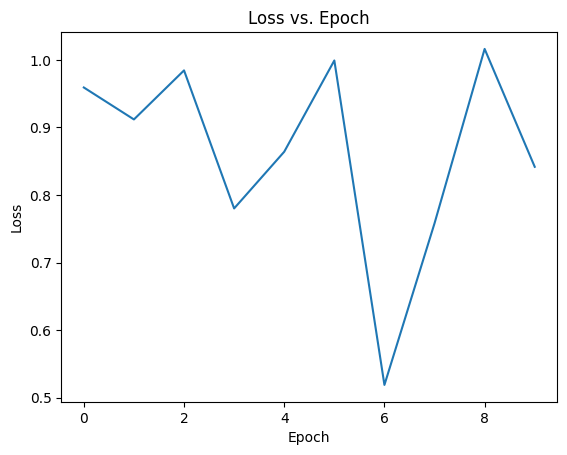

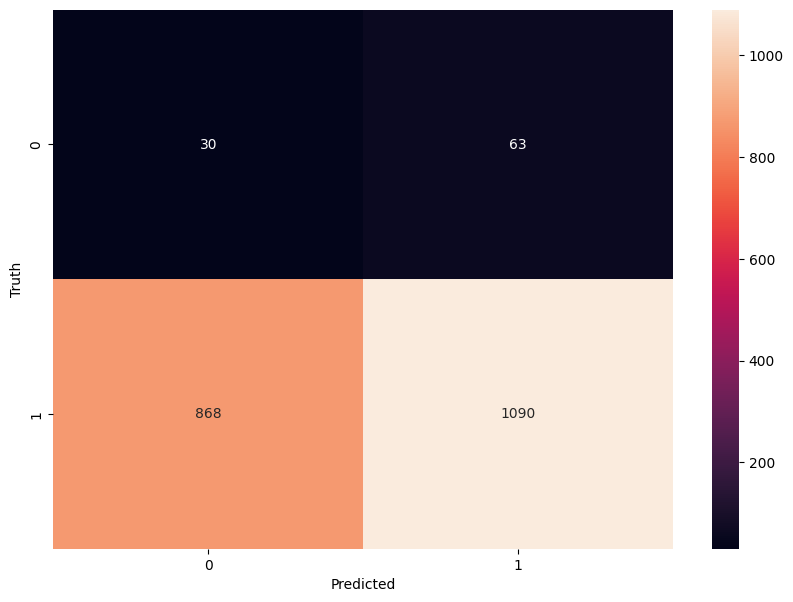

In [159]:
plot_loss_vs_epoch(n_epochs, model_33_loss_list)
plot_confusion_matrix(model_33_true_labels, model_33_predictions)

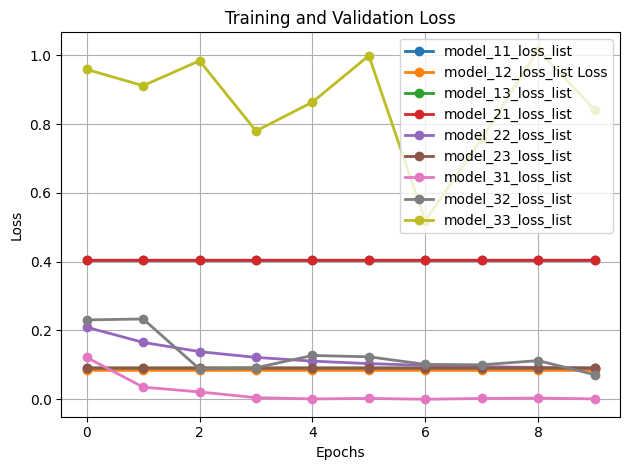

In [171]:

epochs = range(0, n_epochs)  
plt.plot(epochs, model_11_loss_list, label='model_11_loss_list', marker='o', linewidth=2)
plt.plot(epochs, model_12_loss_list, label='model_12_loss_list Loss', marker='o', linewidth=2)
plt.plot(epochs, model_13_loss_list, label='model_13_loss_list', marker='o', linewidth=2)
plt.plot(epochs, model_21_loss_list, label='model_21_loss_list', marker='o', linewidth=2)
plt.plot(epochs, model_22_loss_list, label='model_22_loss_list', marker='o', linewidth=2)
plt.plot(epochs, model_23_loss_list, label='model_23_loss_list', marker='o', linewidth=2)
plt.plot(epochs, model_31_loss_list, label='model_31_loss_list', marker='o', linewidth=2)
plt.plot(epochs, model_32_loss_list, label='model_32_loss_list', marker='o', linewidth=2)
plt.plot(epochs, model_33_loss_list, label='model_33_loss_list', marker='o', linewidth=2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()